## Study if x parameter (L.._x columns) affects average user count in network

Study how a change in cell specific parameter value “_x” affects the
average user count in the network

Dataset specifics:
- Columns ending in "_x" are the x parameter for a cell
- Columns not ending in "_x" but which have the format "L(number)" are the average user count for that cell during time of measurement 
- First rows are datetime info

Overview:
<br>
<h3>Test 1: Test if parameter x affects average user count as a whole</h3>
<Br>
Hypothesis: Changes in parameter X affects average user count on the whole network
<br>
- Treat user count over the network as a whole and x parameter cells as a whole and do plotting
<br>
- If something interesting is found try to find out if there is a correlation
    

Assumptions of test 1:
 - The network as specified in the task means all the measured nodes
 - The candidate columns e.g. ending in x can be measured together as a whole even though assignment refers to them as cell specific parameters
 
<br>
    <h3>Test 2: Test if a single cell and its counterpart column "_x" has any correlation </h3>
<br>
Hypothesis: The cell specific x parameter has a correlation with the cell average user count
<ul>
    <li>
    Test if the two show any significant correlation over time
    </li>
     <li>
    Group by days to get different results 
    </li>
    </ul>
 <br>
Tools used: 
pandas, matplotlib

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
cell_data = pd.read_csv('users.csv', sep=';')

In [4]:
# helper functions

In [5]:
def get_candidate_column_names(df):
    candidate_columns = [column for column in df.columns if column[-1]==('x')]
    return candidate_columns

In [6]:
def get_user_count_column_names(df, candidate_columns):
    all_except_candidate = [column for column in df.columns if column not in candidate_columns]
    other_excluded_cols = ['Time', 'Day', 'Hour', 'Rownum',]
    user_count_columns = [column for column in all_except_candidate if column not in other_excluded_cols]
    return user_count_columns

In [7]:
def comma_string_to_float(string_with_comma):
    return float(string_with_comma.replace(',', '.'))

In [8]:
# separate columns to categories
candidate_columns = get_candidate_column_names(cell_data)
user_count_columns = get_user_count_column_names(cell_data, candidate_columns)

In [9]:
# user count data needs to be cleaned and converted into floats
for column in user_count_columns:
    cell_data[column] = cell_data[column].apply(comma_string_to_float)

In [10]:
# aggregate mean of all candidate column rows
cell_data['candidate_x_mean'] = cell_data[candidate_columns].agg('mean', axis=1)
cell_data['average_user_count_sum'] = cell_data[user_count_columns].agg('sum', axis=1)

In [11]:
# convert timestamp to readable time
cell_data['datetime'] = pd.to_datetime(cell_data["Time"], unit='s')

<h3>Test 1</h3>

<AxesSubplot:xlabel='datetime'>

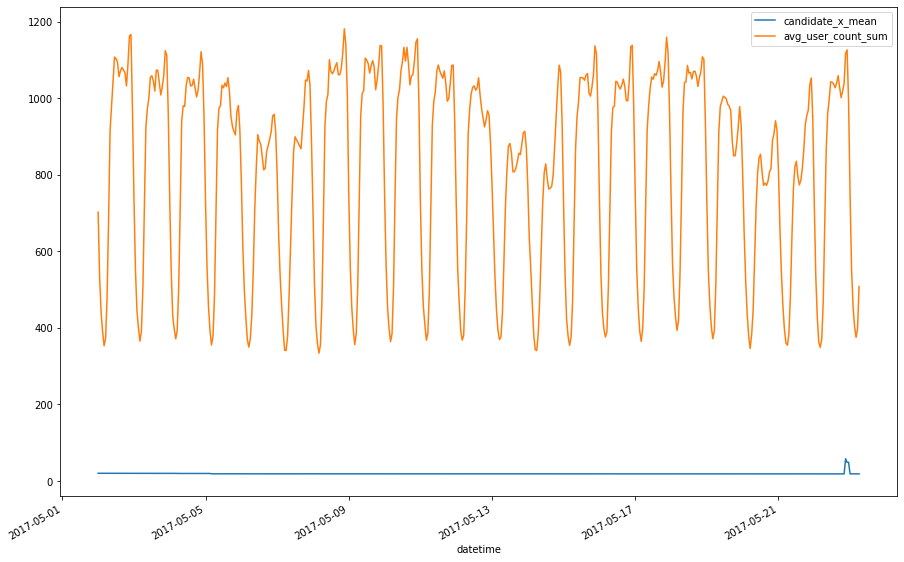

In [39]:
df = pd.DataFrame()
df['candidate_x_mean'] = cell_data['candidate_x_mean']
df['avg_user_count_sum'] = cell_data['average_user_count_sum']
df['datetime'] = cell_data['datetime']

df.plot(x='datetime', figsize=(15,10))

From the above graph you can see that there is no visually significant impact on the x values on the whole networks users. 
Maybe when the x value drops for one cell that cells user count goes down, but it's still adjusted on the full network.

In [14]:
# try to compare pct change instead of the values
cell_data['candidate_x_return'] = cell_data['candidate_x_mean'].pct_change()
cell_data['average_user_count_return'] = cell_data['average_user_count_sum'].pct_change()

<AxesSubplot:xlabel='datetime'>

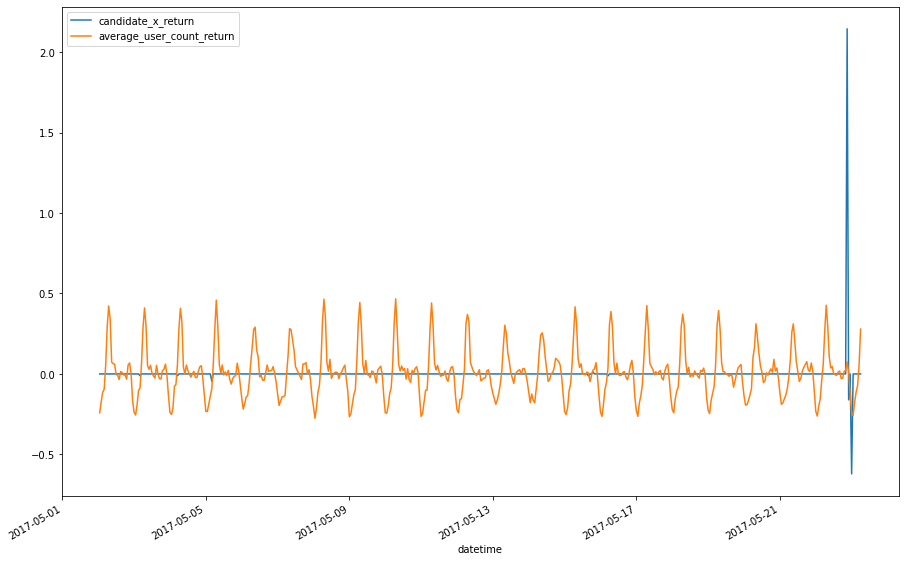

In [16]:
df2 = pd.DataFrame()
df2['candidate_x_return'] = cell_data['candidate_x_return']
df2['average_user_count_return'] = cell_data['average_user_count_return']
df2['datetime'] = cell_data['datetime']

df2.plot(x='datetime', figsize=(15,10))

In [17]:
# lets check a scatter plot

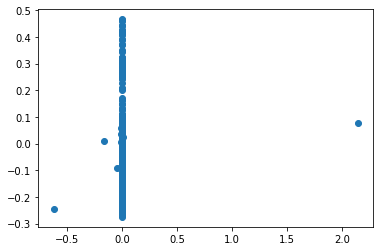

In [19]:
import matplotlib.pyplot as plt
plt.scatter(cell_data['candidate_x_return'], cell_data['average_user_count_return'])

In [20]:
#get correlation
corr = cell_data['candidate_x_return'].corr(cell_data['average_user_count_return'])

In [21]:
corr

0.04132725075981387

As above stated there is no significant correlation between the mean of X parameter and the average user count of the whole network.


In [22]:
# try to do some normalisation, prepare data for ML process if needed. However, normalisation does not effect the results since it only adjusts scale
df3 = pd.DataFrame()
df3['candidate_x_mean'] = cell_data['candidate_x_mean']
df3['average_user_count'] = cell_data['average_user_count_sum']

In [23]:
from sklearn import preprocessing
cell_data_array = preprocessing.normalize(df3, axis=0)
cell_data_normalized = pd.DataFrame(cell_data_array, columns=df3.columns)

In [24]:
cell_data_normalized['datetime'] = cell_data['datetime']

<AxesSubplot:xlabel='datetime'>

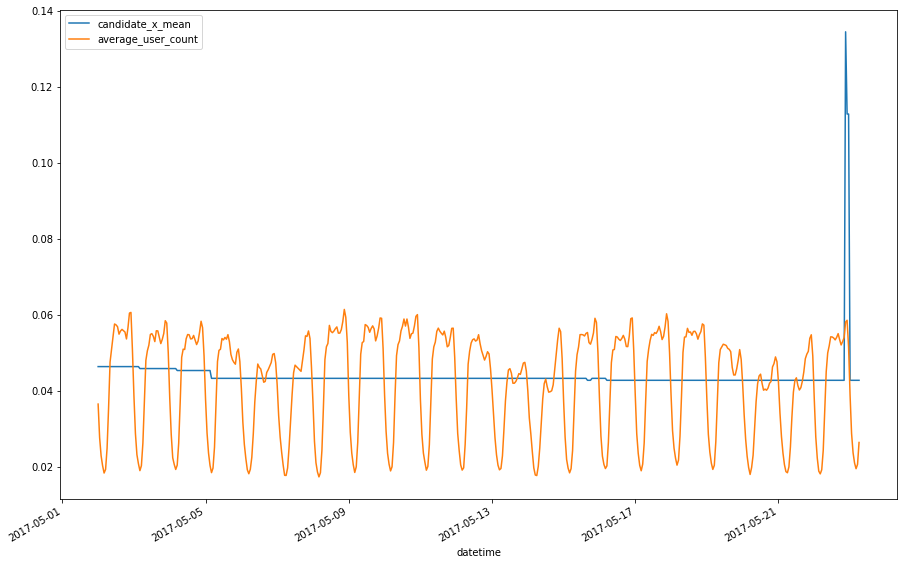

In [25]:
# try to plot
cell_data_normalized.plot(x='datetime', figsize=(15,10))

As stated normalisation does not change the results but graph looks better with one scale

In [26]:
# Checking the return value of the changes over time as a santiy check 
cell_data_normalized['candidate_x_mean_return'] = cell_data_normalized['candidate_x_mean'].pct_change()
cell_data_normalized['average_user_count_return'] = cell_data_normalized['average_user_count'].pct_change()

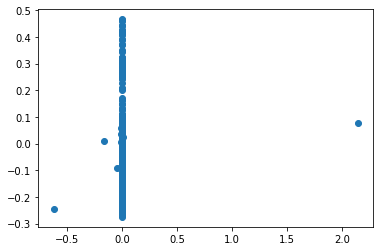

In [27]:
plt.scatter(cell_data_normalized['candidate_x_mean_return'], cell_data_normalized['average_user_count_return'])

In [28]:
corr = cell_data_normalized['candidate_x_mean_return'].corr(cell_data_normalized['average_user_count_return'])

In [29]:
corr

0.04132725075981387

Correlation is as without normalisation the same as it should be

<h3>Test 2</h3>
<br>
When studying the whole network and usign the mean for the X parameter does not seems to have any correlation so the effects of X might be too subtle to tell this way. Lets try to check only one columns e.g. target column L1547777 and corresponding x column

In [32]:
#test only target column and target x for sanity check
df4 = pd.DataFrame()
df4['datetime'] = cell_data['datetime']
df4['L1547777'] = cell_data['L1547777']
df4['L1547777_x'] = cell_data['L1547777_x']

<AxesSubplot:xlabel='datetime'>

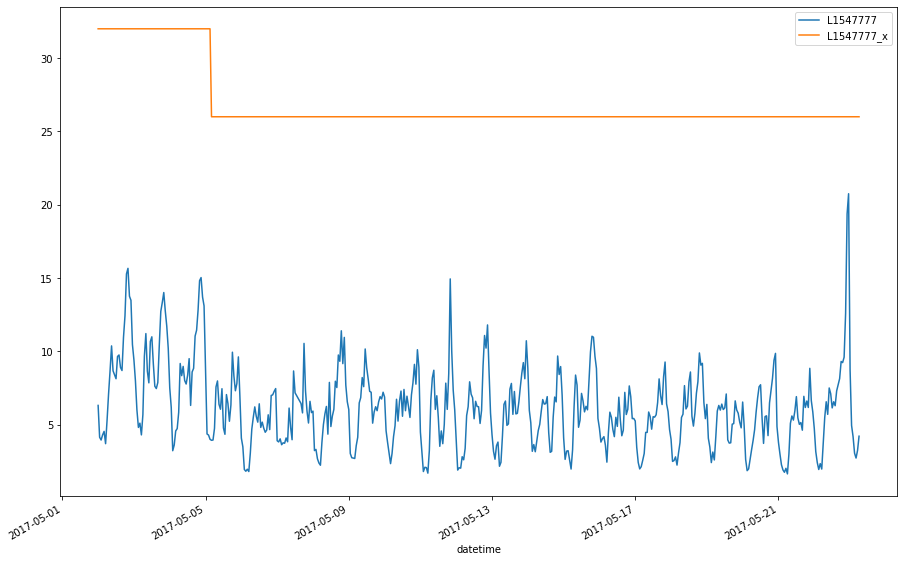

In [33]:
df4.plot(x='datetime', figsize=(15,10))

Only 1 change in the X parameter over the whole time series. At a quick glance you can see that before the drop the highs were higher and after the drop the highs were generally lower except for two outliers. 

Try to group by the daily average to smoothen the curve

<AxesSubplot:xlabel='datetime'>

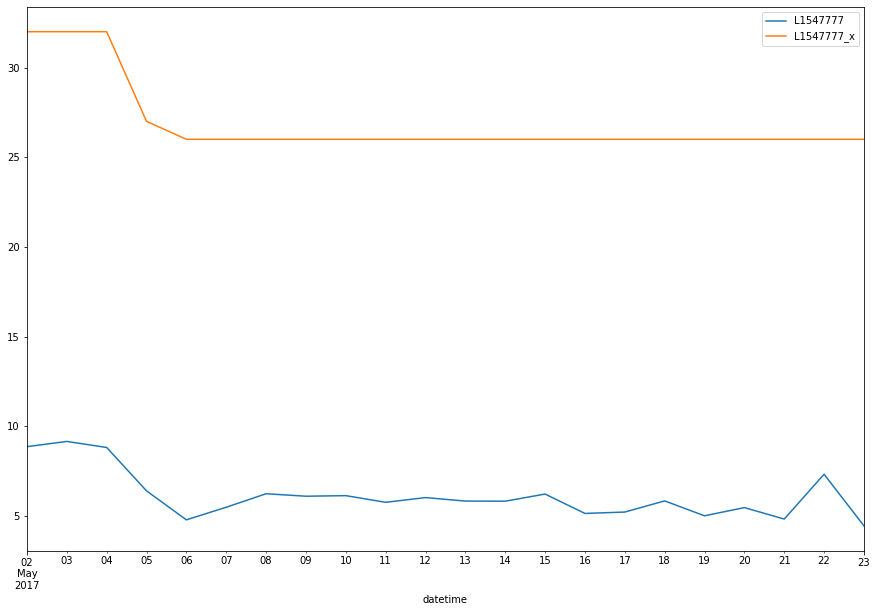

In [34]:
grouped_by_day = df4.resample('D', on='datetime').mean()
grouped_by_day.plot(figsize=(15,10))

There definently seems to be some correlation during the dip and after

In [35]:
corr = grouped_by_day['L1547777_x'].corr(grouped_by_day['L1547777'])
corr

0.8810694275597725

Ok, so there seems to be quite a good correlation between the two values here. Lets try to check if the returns show similar things

In [36]:
df5 = pd.DataFrame()
df5['L1547777_ret'] = grouped_by_day['L1547777'].pct_change()
df5['L1547777_x_ret'] = grouped_by_day['L1547777_x'].pct_change() 

<AxesSubplot:xlabel='datetime'>

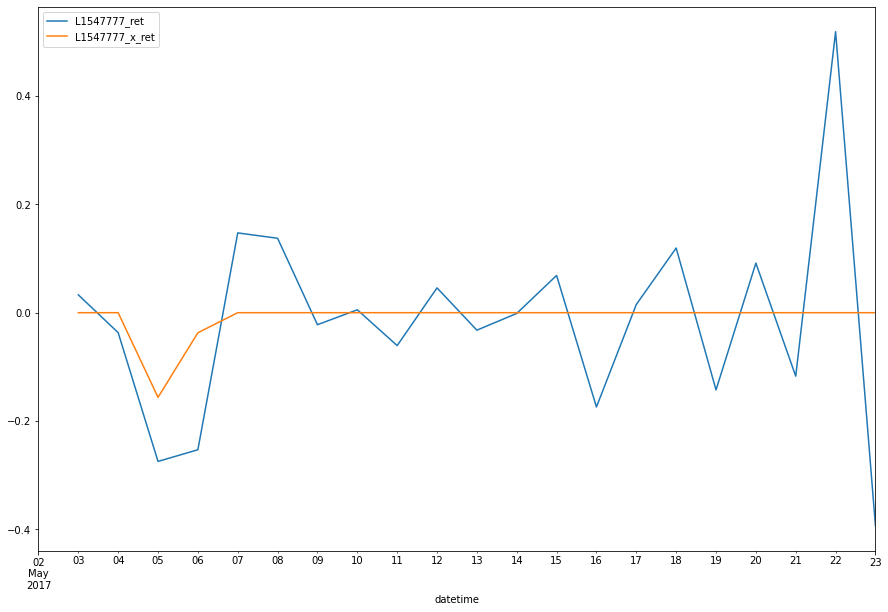

In [37]:
df5.plot(figsize=(15,10))

In [38]:
corr = df5['L1547777_ret'].corr(df5['L1547777_x_ret'])
corr

0.37992933974278986

There is a bit higher correlation between x values and average user count in this one column. However, its still quite weaker than before. 

## Results

The first test was to see if all the x parameters have any effect on the average user count on the whole network. They didnt have an affect with a low correlation. The hypothesis was proven False. 

The second test tested only target column and corresponding X parameter. There was a big dip in the x parameter and a simulataneous dip in the user count. After grouping by day to get a more smooth curve the relations were more visible. Correlation is at 0.88 which is quite high. Hypothesis was proven True and there is some correlation.

So to conclude it seems a single columns x parameter has an effect on the columns daily average user count. E.g. if the X parameter is lower the average user count is lower. The x parameters seem to not have a significant effect on the whole network. It seems the network corrects for one cells drops. Further study is needed if this applies to all cells. 